In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline
from math import floor

In [3]:
import pandas

mnist = pandas.read_csv("mnist-train.csv").to_numpy() # file from https://www.kaggle.com/c/digit-recognizer/data
training = mnist[:,1:]/255.0
labels = mnist[:,0]

Showing: 8


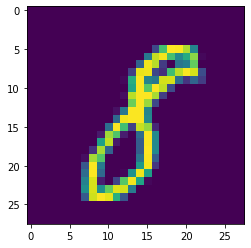

In [4]:

sample_index = 5000
print(f"Showing: {labels[sample_index]}")
plt.imshow(np.reshape(training[sample_index], (28, 28)))

In [5]:
proper_nn_output = np.zeros((labels.shape[0], 10))
for i in range(proper_nn_output.shape[0]):
    proper_nn_output[i] = np.zeros(10)
    proper_nn_output[i][labels[i]] = 1


In [323]:
from enum import Enum

def relu(n):
    return np.maximum(0, n)

def d_relu(n):
    return np.heaviside(n, 1)

def sigmoid(n):
    n = np.clip(n, -400, 400)
    return 1.0 / (1.0 + np.exp(-n))

def d_sigmoid(n):
    n = np.clip(n, -200, 200)
    return np.exp(n)/np.power((np.exp(n) + 1), 2)

class Activation:
    def __init__(self, func, derivative):
        self.func = func
        self.derivative = derivative

RELU = Activation(relu, d_relu)
SIGMOID = Activation(sigmoid, d_sigmoid)

def cross_entropy_loss(proper_output, nn_output):
    nn_output = np.clip(nn_output, 0.01, 0.99)
    return -(proper_output*np.log(nn_output) + (1.0 - proper_output)*np.log(1.0 - nn_output))

def average_cross_entropy_loss(proper_output, nn_output):
    return np.mean(cross_entropy_loss(proper_output, nn_output) , axis=1)

def d_cross_entropy_loss(proper_output, nn_output):
    nn_output = np.clip(nn_output, 0.01, 0.99)
    return -(nn_output - proper_output)/((nn_output - 1)*nn_output)

class NNLayer:
    def __init__(self,size: int, prev_size: int, activation: Activation):
        self.data = np.zeros((size, 1))
        if prev_size != -1:
            self.weights = np.random.uniform(-1.0, 1.0, size=(size, prev_size))
            self.biases = np.random.uniform(0.0, 0.0, size=(size, 1))
            self.activation = activation

class NeuralNet:
    def __init__(self, input_size, layer_sizes, layer_activations):
        assert(len(layer_sizes) == len(layer_activations))
        
        self.layers = [ NNLayer(input_size, -1, None) ]
        
        for i in range(len(layer_sizes)):
            # self.layers[i] should point to the layer before the current one
            self.layers.append(NNLayer(
                layer_sizes[i],
                self.layers[i].data.shape[0],
                layer_activations[i]
            ))
        self.loss = 1000.0
        self.pre_activation_cache = None # list of pre activation layer values
    
    def forward(self, input_data): 
        #assert(input_data.shape == self.layers[0].data.shape)
                                             
        self.pre_activation_cache = [None] * (len(self.layers))
        self.layers[0].data = input_data
        #print(f" data layer shape: {self.layers[0].data.shape}")
        #print(f" output layer shape: {self.layers[1].data.shape}")
        for i in range (1, len(self.layers)): # 0th layer is the data layer
            l = self.layers[i]
            prev_l = self.layers[i - 1]
            self.pre_activation_cache[i] = np.atleast_2d(np.dot(l.weights, prev_l.data)) + np.reshape(l.biases, (l.biases.shape[0], 1))
            #print(f"dot: {np.atleast_2d(np.dot(l.weights, prev_l.data)).shape}")
            #print(f"biases: {np.reshape(l.biases, (l.biases.shape[0], 1)).shape}")
            #print(f"adding them: {(np.atleast_2d(np.dot(l.weights, prev_l.data)) + np.reshape(l.biases, (l.biases.shape[0], 1))).shape}")
            l.data = l.activation.func(self.pre_activation_cache[i])
    
    def get_output(self):
        return self.layers[len(self.layers) - 1].data
    
    def get_loss(self, expected_last_layer):
        return np.sum(cross_entropy_loss(expected_last_layer, self.get_output()))
    
    def backward(self, expected_last_layer): # tunes layers based on the expected value and cache
        learning_rate = 0.01
        #cur_gradient = np.reshape(average_cross_entropy_loss(expected_last_layer, self.get_output()), (expected_last_layer.shape[0], 1))
        cur_gradient = d_cross_entropy_loss(expected_last_layer, self.get_output())
        #print(f"initial gradient: {cur_gradient}")
        #print(cur_gradient)

        for i in range(len(self.layers) - 1, 0, -1): # skip over the first layer as it is the input layer
            #print(self.layers[i].weights.shape)
            #print(self.layers[i-1].data.shape
            #print(self.layers[i].activation.derivative(self.pre_activation_cache[i]).shape)
            #print(cur_gradient.shape)
            #print(f"activation cache shape: {self.pre_activation_cache[i].shape}")
            d_act_of_pre = self.layers[i].activation.derivative(self.pre_activation_cache[i])
            
            #print(f"cur gradient: {cur_gradient.shape}")
            #print(np.reshape(np.mean(d_act_of_pre * cur_gradient, axis=1), (self.layers[i].biases.shape[0], 1)))
            
            #print(f"prev: {self.layers[i - 1].data.shape}")
            #print(f"prev mean: {self.layers[i - 1].data.mean(axis=1).reshape((-1, 1)).T.shape}")
            #print(f"dsig: {d_act_of_pre.mean(axis=0).reshape((-1, 1)).shape}")
            #print(f"dcost: {cur_gradient.mean(axis=0).reshape((-1, 1)).shape}")
            self.layers[i].weights += -learning_rate * (d_act_of_pre * cur_gradient).dot(self.layers[i - 1].data.T) / expected_last_layer.shape[1]
            
            #self.layers[i].weights += -learning_rate * \
            #    self.layers[i - 1].data.mean(axis=1).reshape((-1, 1)).T * \
            #    d_act_of_pre.mean(axis=1).reshape((-1, 1)) * \
            #    cur_gradient.mean(axis=1).reshape((-1, 1)) 
            
            #self.layers[i].weights += -learning_rate * self.layers[i - 1].data.dot(d_act_of_pre.T).T * cur_gradient
            
            #self.layers[i].biases += -learning_rate * np.reshape(np.mean(d_act_of_pre * cur_gradient, axis=1), (self.layers[i].biases.shape[0], 1))
            #self.layers[i].weights += -learning_rate*np.multiply(self.layers[i - 1].data.T, np.reshape(np.multiply(cur_gradient, self.layers[i].activation.derivative(self.pre_activation_cache[i])), (self.layers[i].data.shape[0], 1)))
            #self.layers[i].biases += -learning_rate*cur_gradient
            
            if i > 1: # don't compute the next gradient if it's the layer before the input layer
                #print(self.layers[i].weights.dot(d_act_of_pre).shape)
                #print(f"summed d_act_of_pre: {d_act_of_pre.sum(axis=1).T}")
                cur_gradient = np.sum(self.layers[i].weights.T * d_act_of_pre.T.mean(axis=0) * cur_gradient.T, axis=1)
                #print(cur_gradient)
                cur_gradient = cur_gradient.reshape((cur_gradient.shape[0], 1))
                #cur_gradient = self.layers[i].weights * d_act_of_pre * cur_gradient
                assert(False)
                #cur_gradient = np.multiply(np.dot(self.layers[i].weights.T, cur_gradient), self.layers[i - 1].activation.derivative(self.pre_activation_cache[i-1]))
                
            
            
            

In [324]:
#nn = NeuralNet(len(training[0]), [16, 16, 10], [RELU, RELU, SIGMOID])
nn = NeuralNet(len(training[0]), [10], [SIGMOID])

Test
100


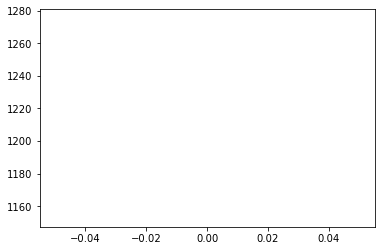

In [325]:
import random
losses = []

for i in range(1):
    # forward prop
    epoch_sample_indices = np.random.randint(training.shape[0], size=100)
    #epoch_sample_indices = [5]
    
    epoch_training = training[epoch_sample_indices,:].T
    epoch_labels = proper_nn_output[epoch_sample_indices,:].T

    #print(epoch_training.shape)
    nn.forward(epoch_training)
    
    assert(nn.get_output().shape == epoch_labels.shape)
    #print(expected_value)
    #print(cur_data)
    #print(cross_entropy_loss(expected_value, cur_data))
   #print(layer_wb_cache[0])
    #loss = np.sum(cross_entropy_loss(expected_value, cur_data))
    losses.append(nn.get_loss(epoch_labels))
    #print(f"Actual number: {actual_number}")
    #print(f"Loss: {losses[-1]}")
    #plt.plot(nn.get_output())
    
    # backprop
    nn.backward(epoch_labels)

plt.plot(losses)


Actual number: 4
Loss: 0.3166136385517381


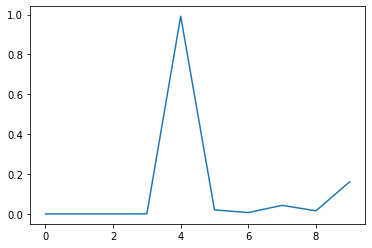

In [318]:
to_predict = random.randint(0, 30000)
#to_predict = 5

actual_number = labels[to_predict]
input_data = training[to_predict]
input_data = np.reshape(input_data, (input_data.shape[0], 1))

expected_value = np.zeros((10, 1))
expected_value[actual_number] = 1

    
nn.forward(input_data)
 
print(f"Actual number: {actual_number}") 
print(f"Loss: {nn.get_loss(expected_value)}")
plt.plot(nn.get_output())

In [ ]:
plt.imshow(nn.layers[1].weights)

In [ ]:
nn.layers[1].weights.shape

In [ ]:
zeros = np.zeros((50, 2))

In [ ]:
zeros.shape

In [ ]:
np.atleast_2d(zeros).shape

In [283]:
x = np.array([
    [1, 2],
    [3, 4],
    [10, 6]
])
y = np.array([
    [2, 3],
    [1, 2],
    [30, 4]
])

In [284]:
(x * y).mean(axis=1).reshape((-1, 1))

array([[  4. ],
       [  5.5],
       [162. ]])

In [285]:
x.mean(axis=1).reshape((-1, 1)) * y.mean(axis=1).reshape((-1, 1))

array([[  3.75],
       [  5.25],
       [136.  ]])